## 国泰君安-数量化专题之七十一：基于微观市场结构的择时策略

In [ ]:
import tushare as ts
import pandas as pd
from datetime import datetime, timedelta

ts.set_token('31daa0c52c01c14860a2289e5ecd7cd39bca4a8e4a8eb94910309d8b')
pro = ts.pro_api()

In [ ]:
#!pip install tushare

In [ ]:
def get_shanghai_index_data(token):

    # 获取上证综指从2006年到2022年的日线数据
    data = pro.index_daily(ts_code='000001.SH', start_date='20060101', end_date='20230822')

    return data

df2006_2022 = get_shanghai_index_data('31daa0c52c01c14860a2289e5ecd7cd39bca4a8e4a8eb94910309d8b')
print(df2006_2022.head())

     ts_code trade_date      close       open       high        low  \
0  000001.SH   20230822  3120.3338  3103.7807  3126.7838  3074.5307   
1  000001.SH   20230821  3092.9777  3125.9897  3134.9571  3092.9777   
2  000001.SH   20230818  3131.9530  3165.0998  3179.1159  3131.9530   
3  000001.SH   20230817  3163.7393  3137.3514  3167.4457  3123.2495   
4  000001.SH   20230816  3150.1277  3164.7019  3176.6260  3149.7226   

   pre_close   change  pct_chg          vol       amount  
0  3092.9777  27.3561   0.8845  309316335.0  348637687.6  
1  3131.9530 -38.9753  -1.2444  265753423.0  293721061.6  
2  3163.7393 -31.7863  -1.0047  294390352.0  320449006.9  
3  3150.1277  13.6116   0.4321  294692586.0  320785474.1  
4  3176.1758 -26.0481  -0.8201  281728292.0  303611332.6  


In [ ]:
df2006_2022.to_csv('df2006_2022.csv')

In [ ]:
# data
df = pd.read_csv('df2006_2022.csv', parse_dates=['trade_date'], dayfirst=True)
df.set_index('trade_date', inplace=True)
df.sort_index(ascending=True,inplace = True )
df['buy_amount'] = df['amount']

# Define S and L
S = 12
L = 26

# 计算S日和L日的移动平均买入额和成交额
df['s_mavg_buy'] = (df['buy_amount'].rolling(window=S).mean() * (S-1) + df['buy_amount'] * 2) / (S+1)
df['l_mavg_buy'] = (df['buy_amount'].rolling(window=L).mean() * (L-1) + df['buy_amount'] * 2) / (L+1)

df['s_mavg_total'] = (df['amount'].rolling(window=S).mean() * (S-1) + df['amount'] * 2) / (S+1)
df['l_mavg_total'] = (df['amount'].rolling(window=L).mean() * (L-1) + df['amount'] * 2) / (L+1)

# 根据上面的计算结果，计算投资者活跃度
df['activity_index'] = (df['s_mavg_buy'] / df['s_mavg_total']) - (df['l_mavg_buy'] / df['l_mavg_total'])

# 可以选择保存结果
df.to_csv('output_with_activity_index.csv')


In [ ]:
mean_volume = df['amount'].mean()
std_volume = df['amount'].std()
df['volume_zscore'] = (df['amount'] - mean_volume) / std_volume

# Step 2: Estimate informed trader's buy amount based on z-score
# We'll assume that the informed trader's buy amount is proportionally affected by the z-score of the volume
df['estimated_buy_amount'] = df['amount'] * (1 + df['volume_zscore'])
df[['amount', 'volume_zscore', 'estimated_buy_amount']].tail()


,amount,volume_zscore,estimated_buy_amount
trade_date,,,
2023-08-16,303611332.6,0.550331,4.706980e+08
2023-08-17,320785474.1,0.651119,5.296551e+08
2023-08-18,320449006.9,0.649145,5.284668e+08
2023-08-21,293721061.6,0.492288,4.383165e+08
2023-08-22,348637687.6,0.814574,6.326288e+08


In [ ]:
# Strategy Implementation
# Continue with the calculation of investor activity index using the estimated buy amount

# Define S and L days for moving averages
S = 12
L = 26

# Compute S-day and L-day moving averages for estimated buy amount and total amount
df['s_mavg_buy'] = (df['estimated_buy_amount'].rolling(window=S).mean() * (S-1) + df['estimated_buy_amount'] * 2) / (S+1)
df['l_mavg_buy'] = (df['estimated_buy_amount'].rolling(window=L).mean() * (L-1) + df['estimated_buy_amount'] * 2) / (L+1)

df['s_mavg_total'] = (df['amount'].rolling(window=S).mean() * (S-1) + df['amount'] * 2) / (S+1)
df['l_mavg_total'] = (df['amount'].rolling(window=L).mean() * (L-1) + df['amount'] * 2) / (L+1)

# Calculate the investor activity index
df['activity_index'] = (df['s_mavg_buy'] / df['s_mavg_total']) - (df['l_mavg_buy'] / df['l_mavg_total'])

df[['estimated_buy_amount', 's_mavg_buy', 'l_mavg_buy', 'activity_index']].tail(10)
#df.set_index('trade_date',inplace = True)
initial_capital = 100000.0  # 设定初始资本为10万
positions = pd.Series(index=df.index).fillna(0.0)
portfolio = pd.DataFrame(index=df.index)
portfolio['positions'] = (df['activity_index'] > 0).astype(int) - (df['activity_index'] < 0).astype(int)
portfolio['stock_returns'] = df['pct_chg'] / 100
portfolio['strategy_returns'] = portfolio['positions'].shift(1) * portfolio['stock_returns']
portfolio['cumulative_strategy_returns'] = (1 + portfolio['strategy_returns']).cumprod()

# Compute the Sharpe ratio
daily_return = portfolio['strategy_returns'].mean()
daily_std = portfolio['strategy_returns'].std()
sharpe_ratio = daily_return / daily_std * (252**0.5)  # annualized

portfolio, sharpe_ratio

# Continue with the calculation of investor activity index using the estimated buy amount

# Define S and L days for moving averages
S = 12
L = 26



df[['estimated_buy_amount', 's_mavg_buy', 'l_mavg_buy', 'activity_index']].tail(10)


<ipython-input-12-70fa7c9d9f67>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  positions = pd.Series(index=df.index).fillna(0.0)


,estimated_buy_amount,s_mavg_buy,l_mavg_buy,activity_index
trade_date,,,,
2023-08-09,4.914702e+08,8.089142e+08,6.711750e+08,0.194582
2023-08-10,4.829450e+08,7.785119e+08,6.648544e+08,0.165334
2023-08-11,5.966681e+08,7.988356e+08,6.756620e+08,0.173450
2023-08-14,5.362004e+08,7.871105e+08,6.723085e+08,0.164845
2023-08-15,4.614690e+08,7.362856e+08,6.654997e+08,0.108035
2023-08-16,4.706980e+08,6.709743e+08,6.654227e+08,0.003987
2023-08-17,5.296551e+08,6.441024e+08,6.637546e+08,-0.038412
2023-08-18,5.284668e+08,6.249276e+08,6.564478e+08,-0.057354
2023-08-21,4.383165e+08,5.855329e+08,6.400604e+08,-0.094092


In [ ]:
initial_capital = 100000.0  # 设定初始资本为10万
positions = pd.Series(index=df.index).fillna(0.0)
portfolio = pd.DataFrame(index=df.index)
#portfolio['date'] = df['trade_date']
portfolio['positions'] = (df['activity_index'] > 0).astype(int) - (df['activity_index'] < 0).astype(int)
portfolio['stock_returns'] = df['pct_chg'] / 100
portfolio['strategy_returns'] = portfolio['positions'].shift(1) * portfolio['stock_returns']
portfolio['cumulative_strategy_returns'] = (1 + portfolio['strategy_returns']).cumprod()
portfolio.sort_index(ascending=True,inplace = True)
#portfolio['date'] = pd.to_datetime(portfolio['date'])
#portfolio.set_index('date',inplace = True)
# Compute the Sharpe ratio
daily_return = portfolio['strategy_returns'].mean()
daily_std = portfolio['strategy_returns'].std()
sharpe_ratio = daily_return / daily_std * (252**0.5)  # annualized

portfolio, sharpe_ratio

<ipython-input-13-07f8eccd51ed>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  positions = pd.Series(index=df.index).fillna(0.0)


(            positions  stock_returns  strategy_returns  \
 trade_date                                               
 2006-01-04          0       0.017145               NaN   
 2006-01-05          0       0.013807          0.000000   
 2006-01-06          0       0.010151          0.000000   
 2006-01-09          0       0.005164          0.000000   
 2006-01-10          0       0.004072          0.000000   
 ...               ...            ...               ...   
 2023-08-16          1      -0.008201         -0.008201   
 2023-08-17         -1       0.004321          0.004321   
 2023-08-18         -1      -0.010047          0.010047   
 2023-08-21         -1      -0.012444          0.012444   
 2023-08-22         -1       0.008845         -0.008845   
 
             cumulative_strategy_returns  
 trade_date                               
 2006-01-04                          NaN  
 2006-01-05                     1.000000  
 2006-01-06                     1.000000  
 2006-01-09     

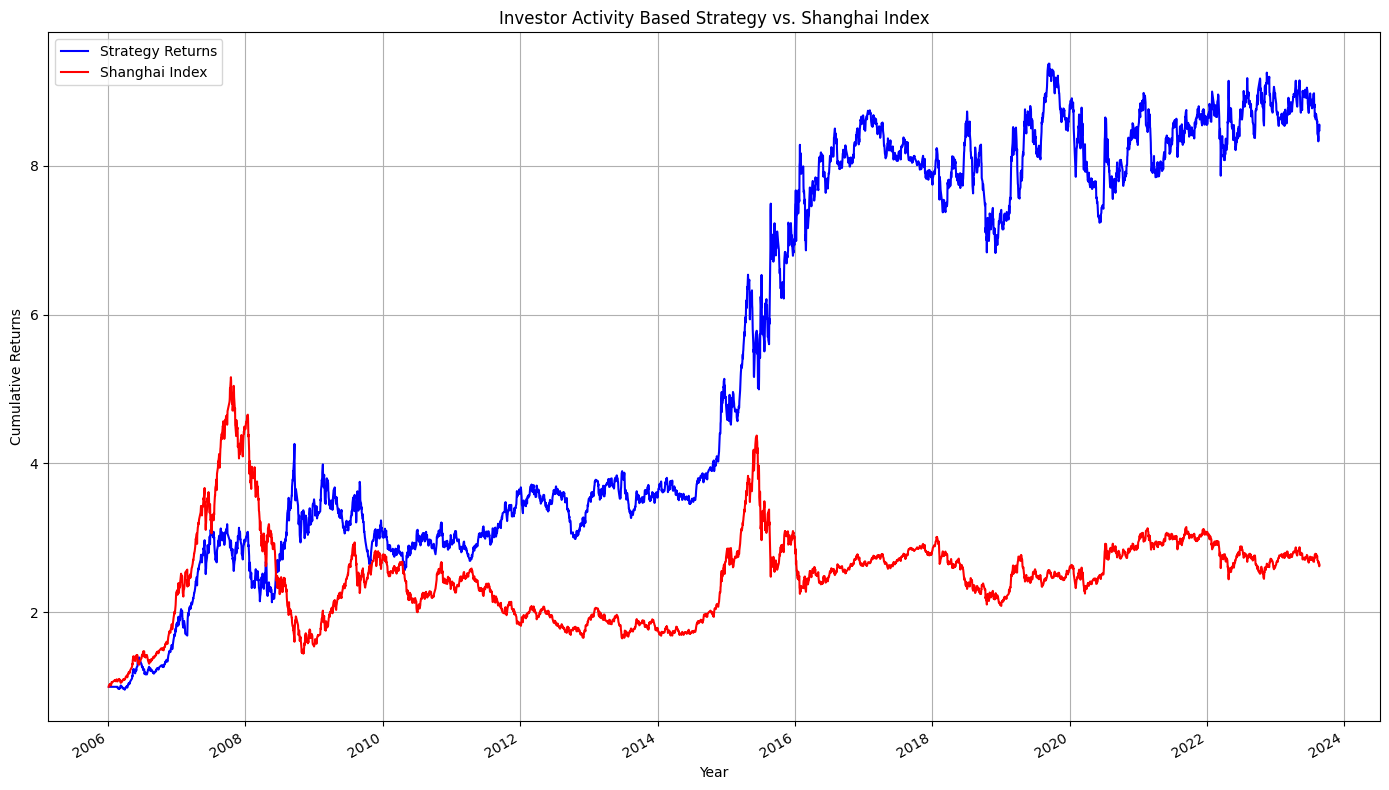

In [ ]:
import matplotlib.pyplot as plt

# Plotting the strategy returns
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the cumulative returns of the strategy
portfolio['cumulative_strategy_returns'].plot(ax=ax, label='Strategy Returns', color='b')

# Plot the Shanghai Index
(df['close'] / df['close'].iloc[0]).plot(ax=ax, label='Shanghai Index', color='r')

# Setting plot title, labels, legend
ax.set(title='Investor Activity Based Strategy vs. Shanghai Index',
       ylabel='Cumulative Returns',
       xlabel='Year')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
##完成！！！
df.to_csv('output_with_activity_index.csv')


In [ ]:
portfolio

,positions,stock_returns,strategy_returns,cumulative_strategy_returns
trade_date,,,,
2006-01-04,0,0.017145,NaN,NaN
2006-01-05,0,0.013807,0.000000,1.000000
2006-01-06,0,0.010151,0.000000,1.000000
2006-01-09,0,0.005164,0.000000,1.000000
2006-01-10,0,0.004072,0.000000,1.000000
...,...,...,...,...
2023-08-16,1,-0.008201,-0.008201,8.326768
2023-08-17,-1,0.004321,0.004321,8.362748
2023-08-18,-1,-0.010047,0.010047,8.446769
